# LDA topic modeling with gensim

Import Libraries

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns

import nltk
nltk.download("omw-1.4")
nltk.download("wordnet")
nltk.download("wordnet2022")

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# useful for storing big datasets
import pickle

#!pip install gensim
import gensim
from gensim.models import CoherenceModel, LdaMulticore

#!pip install pyldavis
import pyLDAvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", message="datetime.datetime.utcnow.*is deprecated")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Read Data

In [4]:
df = pd.read_csv("/content/reviews.csv")
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [5]:
# Use only "Review" and "Rating" Columns
data = df[["Review", "Rating"]]

data.head()

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


In [6]:
# Check data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  61594 non-null  object
 1   Rating  61594 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 962.5+ KB


In [7]:
data.shape

(61594, 2)

Drop duplicate Reviews

In [8]:
data.drop_duplicates(subset="Review", inplace=True, ignore_index=True)
data.shape

/tmp/ipython-input-1022002252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset="Review", inplace=True, ignore_index=True)


(61356, 2)

Create countplot with value counts

<Axes: xlabel='Rating', ylabel='count'>

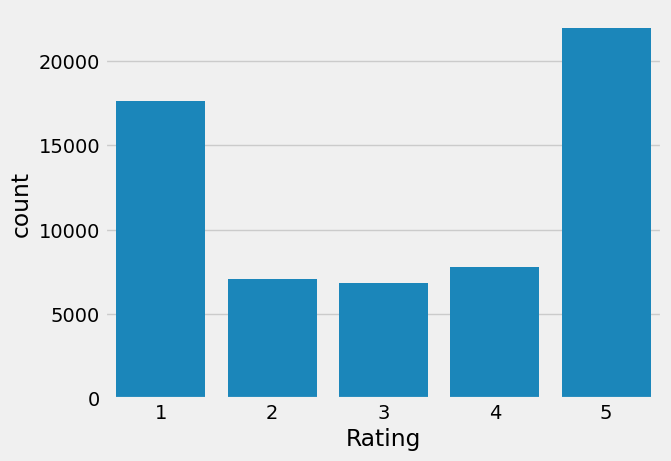

In [9]:
sns.countplot(data, x="Rating")

Data Preparation

1. Remove URLs, mentions and hash tags using the sub function of regular expression package

2. Lowercase each word

3. Replace contractions with their longer forms

In [10]:
def remove_url_mentions_hashtag(text):
  text = re.sub(r"https?://\S+|www\.S+", "", text)
  text = re.sub(r"@\S*", "", text)
  return re.sub(r"#\S*", "", text)

data.Review = data.Review.apply(remove_url_mentions_hashtag)

/tmp/ipython-input-2233801817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Review = data.Review.apply(remove_url_mentions_hashtag)


In [11]:
# Defining Contractions
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"you've": "you have"
}

In [12]:
# Expand Contractions
def remove_contractions(text):
  text = text.lower()

  text = text.split()
  new_text = []

  for word in text:
    if word in contractions:
      new_text.append(contractions[word])
    else:
      new_text.append(word)

  text = " ".join(new_text)
  return text

data.Review = data.Review.apply(remove_contractions)

/tmp/ipython-input-3430680238.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Review = data.Review.apply(remove_contractions)


/tmp/ipython-input-1847533078.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = "words", y = "count", data = _, palette = "winter")


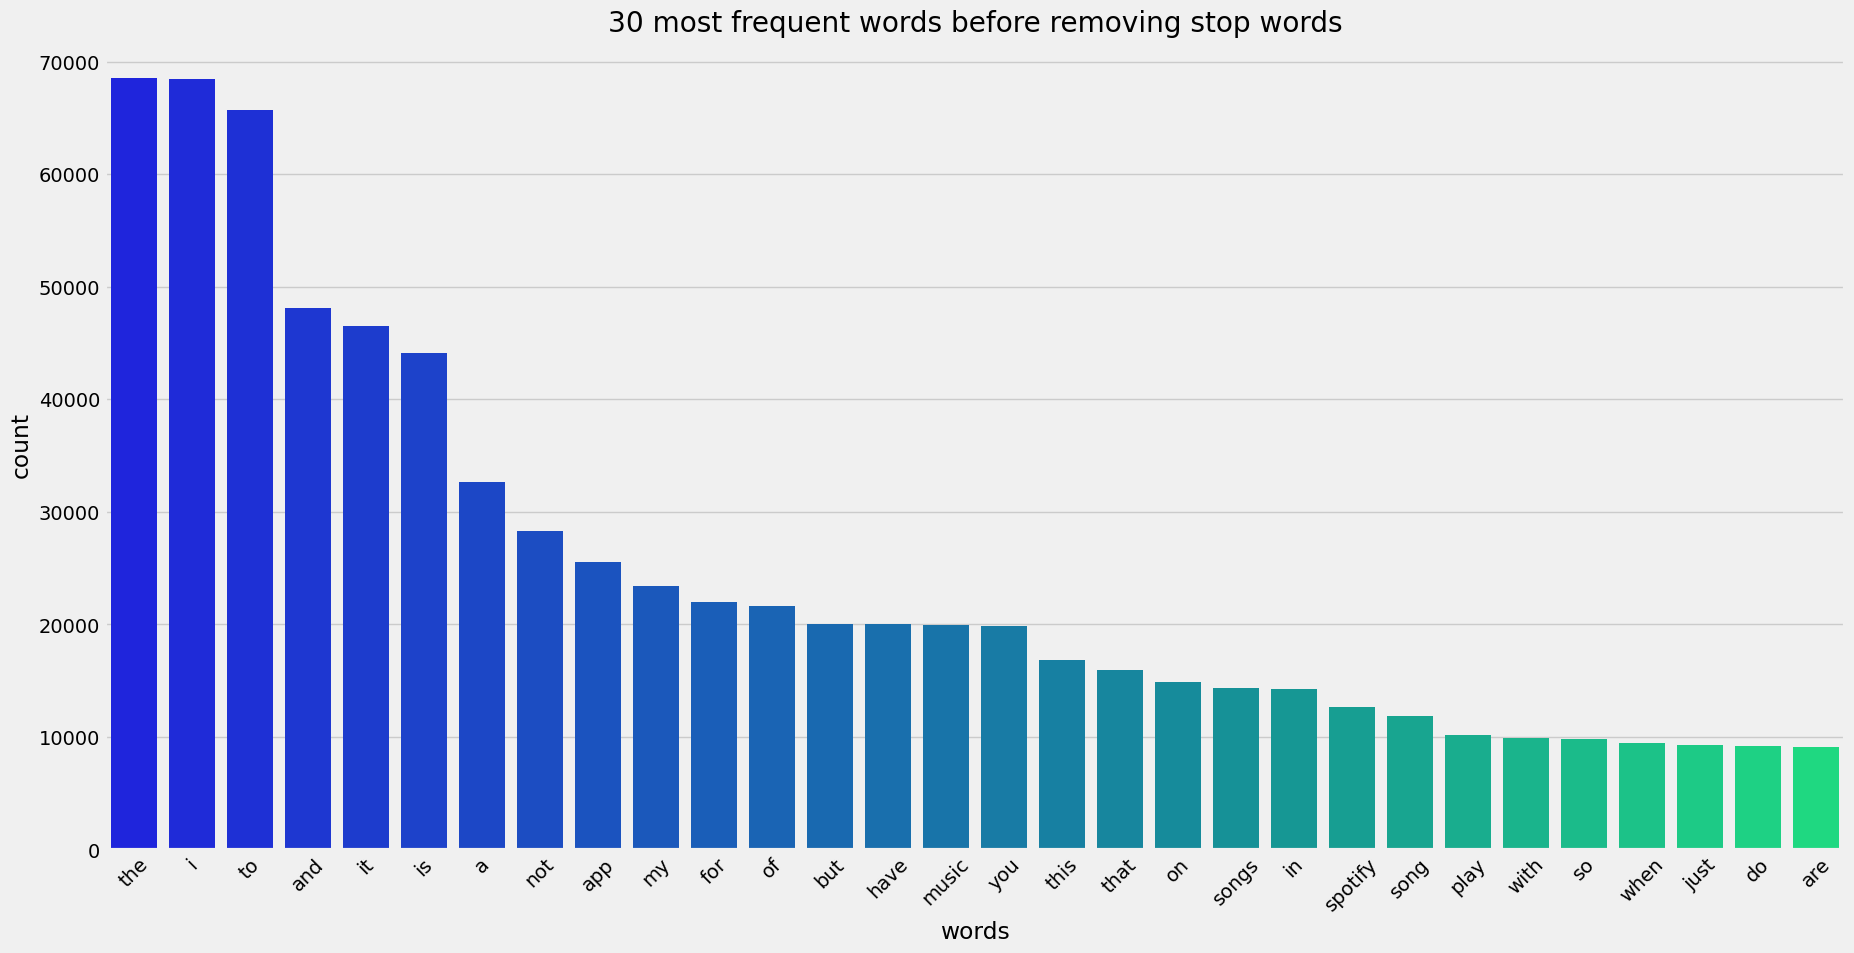

In [13]:
# Join all words
review_words = ",".join(list(data["Review"].values))

# count and find the 30 most frequent
counter = Counter(review_words.split())
most_frequent = counter.most_common(30)

# Bar plot of frequent words
fig = plt.figure(1, figsize = (20, 10))
_ = pd.DataFrame(most_frequent, columns = ("words", "count"))

sns.barplot(x = "words", y = "count", data = _, palette = "winter")
plt.xticks(rotation = 45)
plt.title("30 most frequent words before removing stop words");

Data Preprocessing

1. **Lemmatization : WordNetLemmatizer().lemmatize()** reduces words to their base form or lemma. For example, the lemma of the word "am", "are", and "is" is "be", and the lemma of "running" is "run".

2. **PreProcessing : gensim.utils.simple_preprocess() **preprocess and tokenize text data, which is a necessary step in many natural language processing tasks, like text classification, sentiment analysis, and topic modeling by performing:

a. Lowercasing the text

b. Tokenization

c. Filtering out stop words

d. Filtering out tokens with length less than 2

e. Filtering out tokens with non-alphabetic characters

f. Removing the accents by setting deacc to True

In [14]:
import nltk
nltk.download("stopwords")

stopwords_list = stopwords.words("english")
stopwords_list.extend(["spotify", "app", "song", "music", "songs"])

def lemmatization(text):
  return WordNetLemmatizer().lemmatize(text, pos = "v")

def preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text, deacc = True):
    if token not in gensim.parsing.preprocessing.STOPWORDS and token not in stopwords_list:
      result.append(lemmatization(token))

  return result

data["Review_Clean_List"] = data.Review.apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipython-input-3196872969.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Review_Clean_List"] = data.Review.apply(preprocess)


In [15]:
# Convert List to string
def to_string(text):
  text = " ".join(map(str, text))
  return text

data["Review_Clean"] = list(map(to_string, data["Review_Clean_List"]))

/tmp/ipython-input-2441164494.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Review_Clean"] = list(map(to_string, data["Review_Clean_List"]))


In [16]:
data[data["Review_Clean_List"].str.len() == 0]

,Review,Rating,Review_Clean_List,Review_Clean
1212,100% has everything!,5,[],
3684,in this app all songs are there,3,[],
8899,there are others out there but i always go bac...,5,[],
9201,spotify and only spotify for me!,5,[],
14070,every songs is there !!,5,[],
17678,it does not have all the songs,1,[],
18473,could not ever be without my spotify.,5,[],
20056,all the songs ever made. or most of them..,4,[],
23068,it is spotify after all,5,[],
24259,it has all songs which other song app does not...,5,[],


There are several reviews which become list of empty string after text preprocessing, they should be removed

In [17]:
data = data[data["Review_Clean_List"].str.len() !=0]

/tmp/ipython-input-2623362441.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = "words", y = "count", data = _, palette = "winter")


Text(0.5, 1.0, '30 most frequent words after removing stopwords')

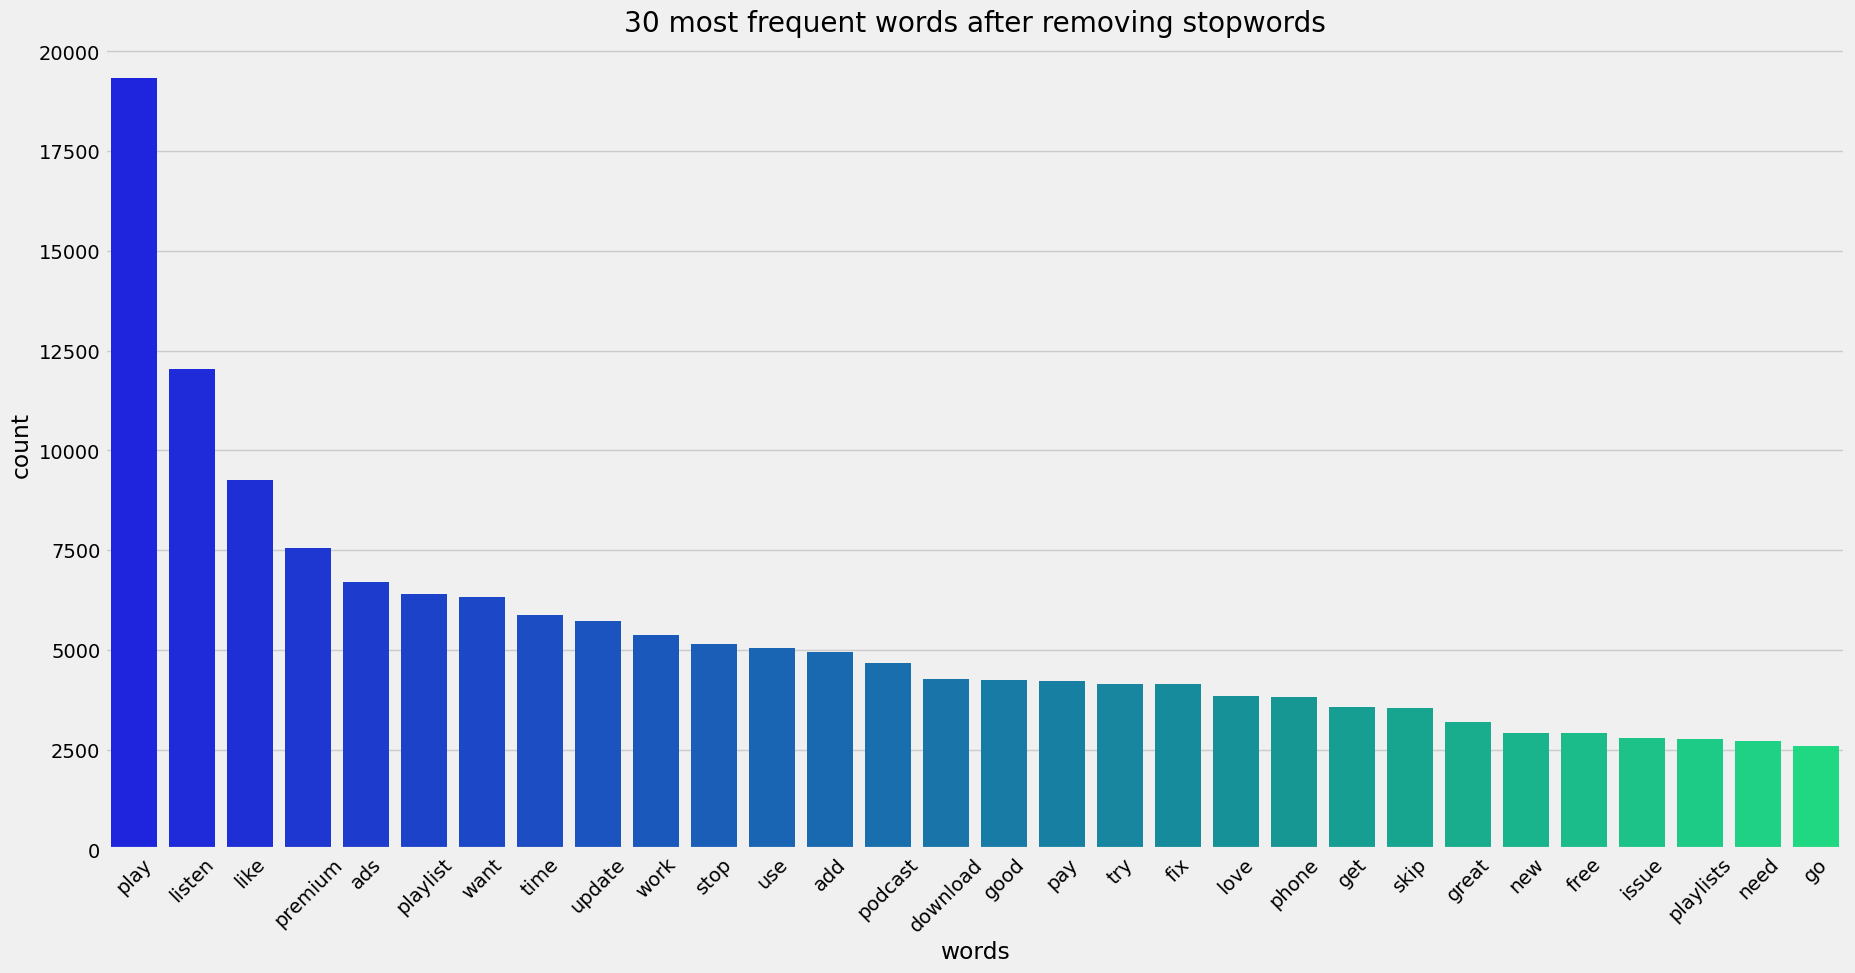

In [18]:
# Join all words
review_words = ",".join(data["Review_Clean"].values)

# Count and find the 30 most frequent
counter = Counter(review_words.split())
most_frequent = counter.most_common(30)

# Bar plot of frequent words
fig = plt.figure(1, figsize = (20, 10))
_ = pd.DataFrame(most_frequent, columns = ("words", "count"))

sns.barplot(x = "words", y = "count", data = _, palette = "winter")
plt.xticks(rotation = 45)
plt.title("30 most frequent words after removing stopwords")

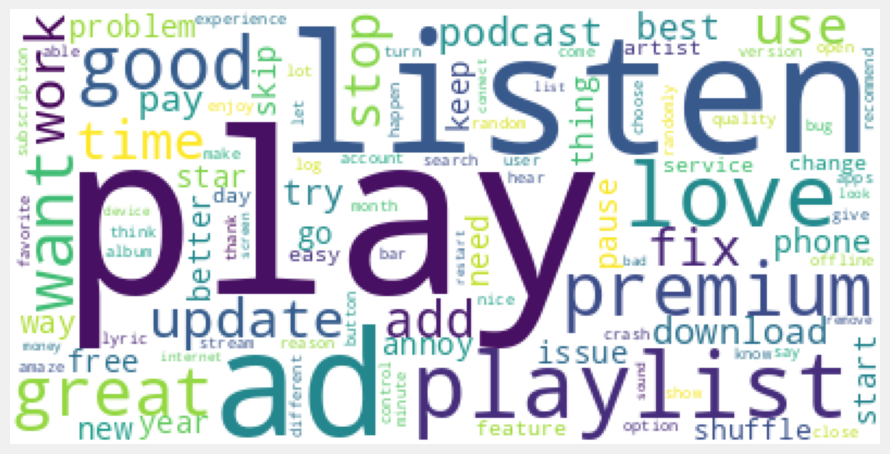

In [19]:
# Generate the word cloud
wordcloud = WordCloud(background_color = "white",
                      max_words = 200,
                      contour_width = 8,
                      contour_color = "steelblue",
                      collocations = False).generate(review_words)

# Visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis("off")
plt.imshow(wordcloud)
plt.show()

Bag-of-words on Document

1. It's **vector space model** which represents the occurrence of words in the document without giving importance to the order or meaning

2. **dictionary** is created using **corpora.Dictionary** of Gensim Package. Here, we map each word with an integer id i.e. id2word

3. **bag-of words** is created using **dictionary.doc2bow**. Here, **doc2bow** function is called on each dictionary to create a list of (id, frequency) tuples.

In [20]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(data["Review_Clean_List"])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data["Review_Clean_List"]]

Determining the Number of Topics

1. Deciding on the number of topics for the topic modeling can be difficult.

2. If this number is too much then the model might fail to detect a topic that is actually broader

3. If this number is too less then topics might have large overlapping words.

4. Here, the topic coherence score comes to rescue

In [21]:
pd.set_option("display.max_colwidth", 15000)
data.sample()

,Review,Rating,Review_Clean_List,Review_Clean
45520,there are alot of ads and also it is hard to find any song,1,"[alot, ads, hard]",alot ads hard


In [22]:
# Compute coherence score
from gensim.models import CoherenceModel
no_of_topics = []
coherence_score = []

for i in range(2,7):
    lda_model = LdaMulticore(corpus=corpus,
                            id2word=id2word,
                            iterations=50,
                            num_topics=i,
                            passes=10,
                            workers=2)

    # Instantiate topic coherence model
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data["Review_Clean_List"], dictionary=id2word, coherence='c_v')

    # Get topic coherence score
    coherence_lda = coherence_model_lda.get_coherence()
    no_of_topics.append(i)
    coherence_score.append(coherence_lda)

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2717) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2717) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2717) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2717) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2717) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:

In [28]:
# Create dataframe of coherence score by number of topics
topic_coherence = pd.DataFrame({"number_of_topics":no_of_topics,
                                "coherence_score":coherence_score})

# Print topic_coherence dataframe
topic_coherence

,number_of_topics,coherence_score
0,2,0.488883
1,3,0.505464
2,4,0.491741
3,5,0.517235
4,6,0.509111


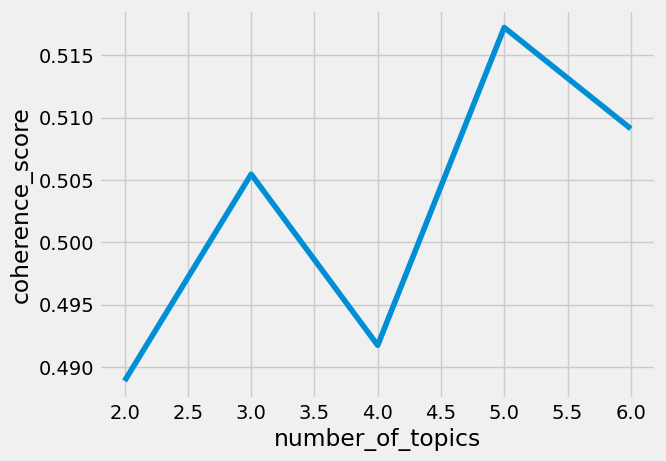

In [29]:
# Print a line plot
sns.lineplot(data = topic_coherence, x = "number_of_topics", y = "coherence_score");

1. Since a very high coherence score (0.549537) is achieved with five topics, we will construct our LDA model with five topics.

2. However, we defined the coherence hyperparameter as coherence='c_v' but there are other options as well such as ‘u_mass’, ‘c_uci’, ‘c_npmi'.

### Topic Modelling with LDA

1. Latent Dirichlet Allocation(LDA) is a statistical unsupervised machine learning model for topic modeling

2. LDA assumes each topic is made up of words and each document (in our case each review) consists of a collection of these words.

3. LDA tries to find words that best describe each topic and matches reviews that are represented by these words.

In [30]:
lda_model_5 = LdaMulticore(corpus, num_topics = 5, id2word = id2word, passes = 8, workers = 3)

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2717) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2717) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2717) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


In [31]:
# Print words occuring in each of the topics
for idx, topic in lda_model_5.print_topics(-1):
  print("\nTopic: {} \nWords: {}".format(idx, topic))


Topic: 0 
Words: 0.041*"best" + 0.038*"add" + 0.037*"playlist" + 0.036*"listen" + 0.034*"like" + 0.021*"love" + 0.019*"podcast" + 0.014*"want" + 0.013*"playlists" + 0.011*"feature"

Topic: 1 
Words: 0.059*"great" + 0.056*"love" + 0.037*"listen" + 0.036*"good" + 0.023*"like" + 0.021*"use" + 0.018*"easy" + 0.017*"amaze" + 0.013*"want" + 0.012*"quality"

Topic: 2 
Words: 0.091*"play" + 0.026*"update" + 0.025*"stop" + 0.021*"fix" + 0.015*"time" + 0.014*"playlist" + 0.014*"work" + 0.013*"want" + 0.013*"phone" + 0.012*"listen"

Topic: 3 
Words: 0.066*"ads" + 0.044*"premium" + 0.022*"listen" + 0.019*"log" + 0.019*"try" + 0.018*"account" + 0.017*"free" + 0.016*"pay" + 0.015*"ad" + 0.015*"good"

Topic: 4 
Words: 0.035*"download" + 0.020*"work" + 0.017*"premium" + 0.016*"service" + 0.015*"pay" + 0.014*"offline" + 0.011*"use" + 0.010*"internet" + 0.008*"phone" + 0.008*"feature"


### Visualizing LDA Results

In [32]:
from pyLDAvis import gensim

vis = pyLDAvis.gensim.prepare(lda_model_5, corpus, id2word, sort_topics = False)

pyLDAvis.display(vis)

On the left side of the the pyLDAvis dashboard, the area of each circle represents the importance of the topic relative to the corpus. In addition, the distance between the center of the circles indicates the similarity between the topics.

Now on the right side of the dashboard, the top 30 relevant words of each topic are displayed in a histogram with the red portion of the bar representing the estimated term frequency within the selected topic (saliency) and the light blue portion representing the overall term frequency.